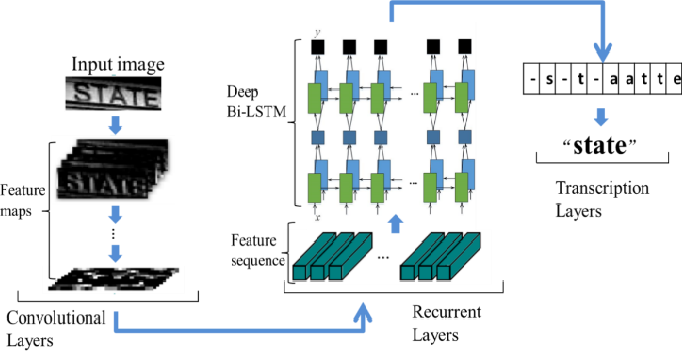

In [1]:
!pip show tensorflow
!pip show keras

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\ghost\anaconda3\envs\daks\lib\site-packages
Requires: tensorflow-intel
Required-by: retina-face
Name: keras
Version: 2.13.1
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\ghost\anaconda3\envs\daks\lib\site-packages
Requires: 
Required-by: mtcnn, tensorflow-intel


In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import csv
from tqdm import tqdm

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

2024-07-28 13:32:48.319405: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 13:32:48.319508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 13:32:48.449012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Save in .csv

In [2]:
language = 'nepali'
color_channel = 'gray'
train_num = "50k"

In [3]:
root_dir = os.path.join(f"/kaggle/input/{language}-{color_channel}-{train_num}")
train_dir = os.path.join(f"/kaggle/input/{language}-{color_channel}-{train_num}/train")
valid_dir = os.path.join(f"/kaggle/input/{language}-{color_channel}-{train_num}/test")

In [4]:
with open(f"{train_dir}/label.txt","r",encoding='utf-8') as f:
    train_label = f.readlines()
    
with open(f"{valid_dir}/label.txt","r",encoding='utf-8') as f:
    valid_label = f.readlines()


In [5]:

# Process each line to extract filename and label
def create_metadata_csv(data, csv_name):
    processed_data = []
    for line in data:
        parts = line.split('\t')
        filename = root_dir + "/" + "/".join(parts[0].split("/")[-2:])
        labels = parts[1].strip()  # Remove trailing newline
        processed_data.append((filename, labels))

    csv_filename = f'{csv_name}.csv'

    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['filename', 'labels'])  # Write header
        csv_writer.writerows(processed_data)

    print(f"Data has been saved to {csv_filename}.")
    
create_metadata_csv(train_label,'train')
create_metadata_csv(valid_label,'valid')

Data has been saved to train.csv.
Data has been saved to valid.csv.


# Visualize

In [6]:
train = pd.read_csv('/kaggle/working/train.csv')
valid = pd.read_csv('/kaggle/working/valid.csv')

In [7]:
valid

,filename,labels
0,/kaggle/input/pracalit-gray-50k/test/1.png,𑐡𑐸𑐧𑐵𑐬𑐵 𑐣𑑂𑐫𑑁𑐥𑐵𑐣𑐎𑐵
1,/kaggle/input/pracalit-gray-50k/test/2.png,𑐦𑐣𑑂𑐡𑐵 𑐣𑐩𑐵𑐣𑑂𑐣𑐾𑐴𑐬𑐸
2,/kaggle/input/pracalit-gray-50k/test/3.png,𑐡𑐺𑐲𑑂𑐫𑐎𑑂𑐲𑐾𑐟𑑂𑐬
3,/kaggle/input/pracalit-gray-50k/test/4.png,𑐐𑐾𑐚𑐎𑐶𑐥𑐶𑐒 𑐐𑐵𑐖𑐵
4,/kaggle/input/pracalit-gray-50k/test/5.png,𑐄𑐏𑐾𑐮𑑂𑐣𑐸𑐨𑐫𑑀 ?
...,...,...
4995,/kaggle/input/pracalit-gray-50k/test/4996.png,𑐴𑐬𑐡𑐩𑐎𑑀
4996,/kaggle/input/pracalit-gray-50k/test/4997.png,𑐴𑐳𑐶𑐣𑐵𑐎𑑀 𑐄𑐟𑐵𑐬𑐶𑐣𑑂𑐕 𑑋
4997,/kaggle/input/pracalit-gray-50k/test/4998.png,"𑐕𑐸𑐚𑑂𑐚𑑂𑐫𑐵𑐊𑐬 𑐧𑐵𑐢𑑂𑐫𑐟𑐵𑐮𑐾 ,"
4998,/kaggle/input/pracalit-gray-50k/test/4999.png,𑐁𑐡𑐾𑐱𑐰𑐶𑐬𑐹𑐡𑑂𑐢 𑐦𑐣𑑂𑐎𑐾


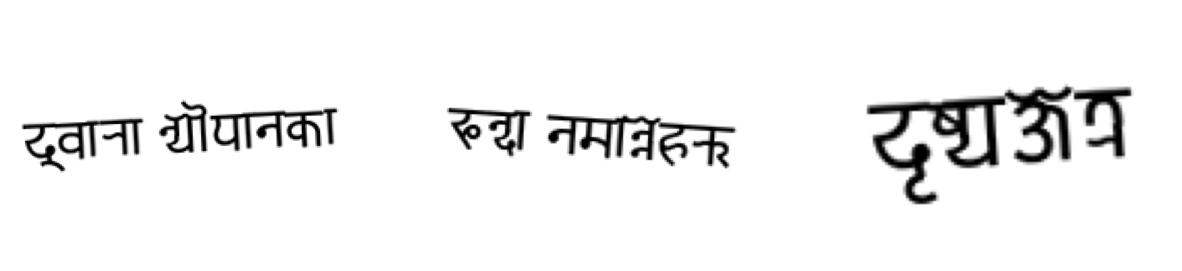

In [8]:
plt.figure(figsize=(15, 10))

for i in range(3):
    ax = plt.subplot(3,3,i+1)
    img_dir = valid.loc[i, 'filename']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
#     plt.title(train.loc[i, 'labels'], fontsize=12 ,font="")
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Preprocessing and preparing the images for training

* The images are loaded as grayscale and reshaped to width 256 and height 64.  
* The width and height are cropped if they are greater than 256 and 64 respectively. If they are smaller, then the image is padded with white pixels. Finally the image is rotated clockwise to bring the image shape to (x, y). 
* The image is then normalized to range [0, 1]

In [9]:
def preprocess(img):
    target_shape = (64, 256)

    # Resize the image
    resized_image = cv2.resize(img, (target_shape[1], target_shape[0]))

    return cv2.rotate(resized_image, cv2.ROTATE_90_CLOCKWISE)

The model will be trained on 30000 images and validate on 3000 images

In [10]:
train = pd.read_csv('/kaggle/working/train.csv')
valid = pd.read_csv('/kaggle/working/valid.csv')

In [11]:
train_size = 50000
valid_size= 5000

In [12]:
train = train[:train_size].reset_index(drop=True)
valid = valid[:valid_size].reset_index(drop=True)

In [13]:
valid.head()

,filename,labels
0,/kaggle/input/pracalit-gray-50k/test/1.png,𑐡𑐸𑐧𑐵𑐬𑐵 𑐣𑑂𑐫𑑁𑐥𑐵𑐣𑐎𑐵
1,/kaggle/input/pracalit-gray-50k/test/2.png,𑐦𑐣𑑂𑐡𑐵 𑐣𑐩𑐵𑐣𑑂𑐣𑐾𑐴𑐬𑐸
2,/kaggle/input/pracalit-gray-50k/test/3.png,𑐡𑐺𑐲𑑂𑐫𑐎𑑂𑐲𑐾𑐟𑑂𑐬
3,/kaggle/input/pracalit-gray-50k/test/4.png,𑐐𑐾𑐚𑐎𑐶𑐥𑐶𑐒 𑐐𑐵𑐖𑐵
4,/kaggle/input/pracalit-gray-50k/test/5.png,𑐄𑐏𑐾𑐮𑑂𑐣𑐸𑐨𑐫𑑀 ?


In [14]:
train_x = []

for i in tqdm(range(train_size)):
    img_dir = train.loc[i, 'filename']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255
    train_x.append(image)

100%|██████████| 50000/50000 [05:03<00:00, 164.83it/s]


In [15]:
valid_x = []

for i in tqdm(range(valid_size)):
    img_dir = valid.loc[i, 'filename']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255
    valid_x.append(image)

100%|██████████| 5000/5000 [00:29<00:00, 169.85it/s]


In [16]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)#array will get reshaped in such a way that the resulting array has only 1 column
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1) #(16384,1)

print("done")

done


## Preparing the labels for CTC Loss

Learn more about CTC loss and why its amazing for text recognition from [here](https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (-  '  and space). 

In [17]:
with open(f"/kaggle/input/{language}-{color_channel}-{train_num}/{language}_dict.txt","r",encoding='utf-8') as f:
    char_dict = f.readlines()

cleaned_list = [char.strip() for char in char_dict]

# Join all characters into a single string
alphabets = "".join(cleaned_list)
alphabets = alphabets + " "
print(alphabets)
print(len(alphabets))

=𑑓𑐕𑐐%𑐑𑑋𑐔𑐸𑐌𑐮𑐀𑐹૪𑐾Þ𑑑𑐝≈𑐣𑑙|𑑕𑐨•𑐺𑐴‚𑐎𑑁𑐰𑑌𑐧𑐦)𑑗;𑐵𑐞𑐜𑑖.𑑘´𑐲𑑅©𑐡𑐃𑐊𑐳 𑐍😠†𑑔𑐇‐𑐢𑑆𑐱𑐟𑐶œ𑑄𑐠𑐥!𑐿𑐷𑑀…𑐋𑐩𑐫𑑃𑐘𑐆øº𑐂𑐁:(𑐄ìÙ𑑒¬𑑂𑐬𑐛𑑇¸∕-$Œ?𑐖á𑐅𑐒¨ְ¥𑐏𑐚𑑉𑐗𑑐,­÷ 
120


In [18]:
dd = train.loc[0]['labels']

In [19]:

max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank(epsilon)
num_of_timestamps = 64 # max length of predicted labels

def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch)) 
        #find() method returns the lowest index of the substring if it is found in given string otherwise -1
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [20]:
name = valid.loc[0]['labels']
print(name, '\n',label_to_num(name))
print(len(label_to_num(name)))

𑐡𑐸𑐧𑐵𑐬𑐵 𑐣𑑂𑐫𑑁𑐥𑐵𑐣𑐎𑐵 
 [50  8 33 38 94 38 54 20 93 78 30 70 38 20 29 38]
16


* **train_y** contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len. 
* **train_label_len** contains the length of each true label (without padding) 
* **train_input_len** contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.  
* **train_output** is a dummy output for ctc loss. 


# Remove long sequences

In [21]:
train_y = np.ones([train_x.shape[0], max_str_len]) * -1
train_label_len = np.zeros([train_x.shape[0], 1])
train_input_len = np.ones([train_x.shape[0], 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_x.shape[0]])

In [22]:
mask = np.ones(train_x.shape[0], dtype=bool)

for i in range(train_x.shape[0]):
    label_len = len(label_to_num(train.loc[i, 'labels']))
    
    if label_len > max_str_len:
        mask[i] = False

train = train[mask].reset_index(drop=True)
train_x = train_x[mask]
train_y = train_y[mask]

train_size = train_x.shape[0] 
print("Updated train_size:", train_size)
print("Length of train_y:", train_y.shape[0])

Updated train_size: 48142
Length of train_y: 48142


In [23]:
train_label_len = np.zeros([train_x.shape[0], 1])
train_input_len = np.ones([train_x.shape[0], 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_x.shape[0]])

In [24]:
valid_y = np.ones([valid_x.shape[0], max_str_len]) * -1
valid_label_len = np.zeros([valid_x.shape[0], 1])
valid_input_len = np.ones([valid_x.shape[0], 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_x.shape[0]])

In [25]:
mask = np.ones(valid_x.shape[0], dtype=bool)
for i in range(valid_x.shape[0]):
    label_len = len(valid.loc[i, 'labels'])
    
    if label_len > max_str_len:
        mask[i] = False

valid = valid[mask].reset_index(drop=True)
valid_x = valid_x[mask]
valid_y = valid_y[mask]

valid_size = valid_x.shape[0] 
print("Updated valid_size:", valid_size)
print("Length of valid_y:", valid_y.shape[0])

Updated valid_size: 4831
Length of valid_y: 4831


In [26]:
valid_label_len = np.zeros([valid_x.shape[0], 1])
valid_input_len = np.ones([valid_x.shape[0], 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_x.shape[0]])

In [27]:
for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'labels'])
    train_y[i, 0:len(train.loc[i, 'labels'])]= label_to_num(train.loc[i, 'labels'])

In [28]:
for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'labels'])
    valid_y[i, 0:len(valid.loc[i, 'labels'])]= label_to_num(valid.loc[i, 'labels'])    

In [29]:
print('True label : ',train.loc[1, 'labels'] , '\ntrain_y : ',train_y[1],'\ntrain_label_len : ',train_label_len[1], 
      '\ntrain_input_len : ', train_input_len[1])

True label :  𑐬𑑀𑐎𑑂𑐣𑐸𑐴𑐸𑐣𑑂𑐕 , 
train_y :  [ 94.  74.  29.  93.  20.   8.  27.   8.  20.  93.   2.  54. 116.  -1.
  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.] 
train_label_len :  [13.] 
train_input_len :  [62.]


In [30]:
print(len(train_x))
print(len(valid_x))

48142
4831


## Building our model


In [31]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.2)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.2)(inner)

target = inner.shape

# CNN to RNN
inner = Reshape(target_shape=((target[1], target[2]*target[3])), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 256, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 256, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 128, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 64, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling2D)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (Bidirectional)           │ (None, 64, 512)        │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (Bidirectional)           │ (None, 64, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64, 121)        │        62,073 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 64, 121)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,453,561 (9.36 MB)

 Trainable params: 2,453,113 (9.36 MB)

 Non-trainable params: 448 (1.75 KB)

The output shape of the predictions is (64, 30). The model predicts words of 64 characters and each character contains the probability of the 30 alphabets which we defined earlier.  

In [32]:
# the ctc loss function
# def ctc_lambda_func(args):
#     y_pred, labels, input_length, label_length = args
#     # the 2 is critical here since the first couple outputs of the RNN
#     # tend to be garbage
#     y_pred = y_pred[:, 2:, :]
#     return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    
    return tf.keras.backend.ctc_batch_cost(y_true = labels, y_pred =  y_pred,input_length = input_length, label_length = label_length)

In [33]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [34]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
# batch_size = 32

# initial_learning_rate = 0.001
# steps_per_epoch = train_x.shape[0]//batch_size
# print(steps_per_epoch)

In [35]:
# learning_rate_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate = initial_learning_rate,decay_steps=steps_per_epoch)

model_final.compile(
    loss={'ctc': lambda y_true, y_pred: y_pred},
    optimizer=Adam(learning_rate=0.001),
     metrics=['accuracy']
)


In [36]:

checkpoint = ModelCheckpoint(filepath='best_model.keras', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

callbacks_list = [checkpoint]

## Train our model

In [37]:
history = model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),callbacks=callbacks_list,verbose=2,epochs=100, batch_size=32, shuffle=True)

Epoch 1/100


2024-07-28 13:39:10.089520: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_loss improved from inf to 8.62798, saving model to best_model.keras


/opt/conda/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss={'ctc': lambda y_true, y_pred: y_pred},

  return {key: serialize_keras_object(value) for key, value in obj.items()}


1505/1505 - 98s - 65ms/step - accuracy: 0.0200 - loss: 23.4671 - val_accuracy: 0.0449 - val_loss: 8.6280
Epoch 2/100

Epoch 2: val_loss improved from 8.62798 to 2.82210, saving model to best_model.keras
1505/1505 - 87s - 58ms/step - accuracy: 0.2555 - loss: 4.1818 - val_accuracy: 0.4301 - val_loss: 2.8221
Epoch 3/100

Epoch 3: val_loss improved from 2.82210 to 2.48649, saving model to best_model.keras
1505/1505 - 141s - 94ms/step - accuracy: 0.4590 - loss: 2.4806 - val_accuracy: 0.5028 - val_loss: 2.4865
Epoch 4/100

Epoch 4: val_loss did not improve from 2.48649
1505/1505 - 142s - 94ms/step - accuracy: 0.5664 - loss: 1.8560 - val_accuracy: 0.4597 - val_loss: 3.4912
Epoch 5/100

Epoch 5: val_loss improved from 2.48649 to 1.62598, saving model to best_model.keras
1505/1505 - 87s - 58ms/step - accuracy: 0.6372 - loss: 1.4727 - val_accuracy: 0.6758 - val_loss: 1.6260
Epoch 6/100

Epoch 6: val_loss did not improve from 1.62598
1505/1505 - 87s - 58ms/step - accuracy: 0.6874 - loss: 1.2203 -

In [38]:
model.save('/kaggle/working/latest_model.keras')

In [39]:
model.load_weights('/kaggle/working/best_model.keras')

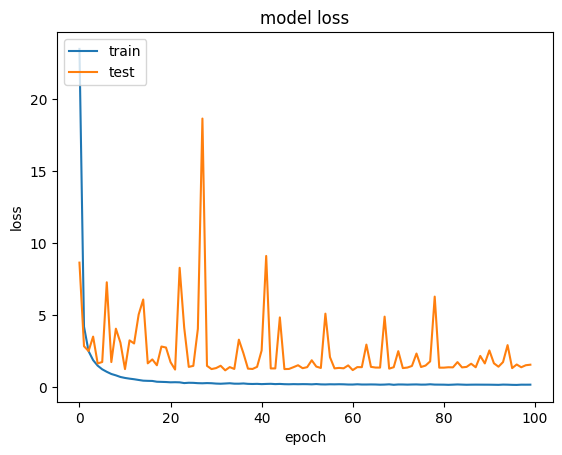

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Check model performance on validation set

In [41]:
preds = model.predict(valid_x)

# Define input_length for CTC decoding
input_length = np.ones(preds.shape[0]) * preds.shape[1]  # Same length for all sequences

# Convert numpy arrays to TensorFlow tensors
preds_tensor = tf.convert_to_tensor(preds, dtype=tf.float32)
input_length_tensor = tf.convert_to_tensor(input_length, dtype=tf.int32)

# Perform CTC decoding
decoded, _ = tf.keras.backend.ctc_decode(preds_tensor, input_length=input_length_tensor, greedy=True)

# Extract the decoded values
decoded_np = decoded[0].numpy()  # Convert tensor to numpy array

# Assuming num_to_label is a function that maps label indices to strings
prediction = [num_to_label(decoded_np[i]) for i in range(preds.shape[0])]

print(prediction)

151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
['𑐺𑐡𑐸𑐧𑐵𑐬𑐵 𑐣𑑂𑐫𑑁𑐥𑐵𑐣𑐎𑐵', '𑐦𑐣𑑂𑐡𑐵 𑐣𑐩𑐵𑐣𑑂𑐣𑐾𑐴𑐬𑐸', '𑐡𑐺𑐲𑑂𑐫𑐎𑑂𑐲𑐾𑐟𑑂𑐬', '(𑐐𑐾𑐚𑐎𑐶𑐥𑐶𑐒 𑐐𑐵𑐖𑐵', '𑐄𑐏𑐾𑐮𑑂𑐣𑐸𑐨𑐫𑑀 ?', '𑑒𑑘𑑑 𑐳𑐸𑐜𑐵𑐣𑐮𑐾', '𑐎𑐸𑐮𑑂𑐮𑐷', '𑐰𑐴𑐞𑑂𑐜𑐬', '𑐥𑐾𑐳𑐵𑐮𑐾 𑐩𑐣𑐶𑐬𑐵𑐩', '𑐧𑑂𑐫𑐵𑐠𑑀𑐮𑑀𑐖𑐷𑐎𑑀', '𑐬𑐵𑐖𑐢𑐵𑐣𑐷𑐧𑐵𑐳𑐷𑐮𑐾 𑐄𑐥𑐳𑐔𑐶𑐰𑐎𑐵', '𑐥𑐟𑑂𑐣𑐷𑐩𑐵𑐠𑐶 𑐀𑐜𑑂𑐎𑐶𑐊𑐎𑐵', '𑐥𑐵𑐂𑐣𑑂𑐣 ,', '𑐀𑑄 𑐐𑐞𑐟𑐣𑑂𑐟𑑂𑐬𑐨𑐶𑐟𑑂𑐬𑐿', '𑐰𑐶𑐖𑐣𑐾𑐳', '𑐕𑐵𑐄𑐣𑐷𑐩𑐿 𑐜𑐩𑑂𑐥𑐶𑐒', '𑐴𑐾𑐜𑐬𑐎𑑀 𑐥𑐬𑐶𑐣𑐾', '𑐐𑐸𑐜𑐧𑐵𑐃 𑐥𑑂𑐬𑐎𑐺𑐟𑐷', '𑐀𑐴𑐶𑐮𑐾𑐎𑐷 𑐧𑑂𑐬𑐵𑑃', '𑐣𑐵𑐬𑐵𑐫𑐞𑐐𑐝 ,', '𑑄𑐳𑐵𑐄𑐡𑐷𑐎𑑀', '𑐀𑐣𑐸𑐨𑐵𑐰', '𑐣𑐾𑐟𑐺𑐟𑑂𑐰𑐨𑐣𑑂𑐡𑐵', '𑑄𑐳𑐶𑐣𑐾𑐥𑑂𑐬𑐾𑐎𑑂𑐳𑐎𑑀 𑐁𑐥𑐟𑑂𑐟𑐶 ?', '𑐰𑐶𑐡𑑂𑐫𑐵𑐎𑑀', '𑐁𑐒𑑂𑐧𑐸𑐴𑐵𑐒𑑂𑐐𑐮𑐵𑐃', '𑐖𑐫𑐥𑐸𑐬', '𑐡𑐷𑐬𑑂𑐑𑐬𑑀𑐐𑐎𑑀', '𑐺𑐳𑐥𑑂𑐬𑑀𑐟𑐩𑐵𑐠𑐶 𑐐𑐐𑐣𑐐𑑁𑑃𑐜𑐵𑐧𑐵𑐚', '𑑄𑐏𑐾𑐮𑐧𑐵𑐬𑐾 𑐄𑐥', '𑐥𑑂𑐬𑐟𑑂𑐫𑐵𑐬𑑀𑐥𑐞 𑐧𑐸𑐮𑐵𑐣𑐡𑐾𑐰', '𑑄𑐏𑐾𑐳𑑂𑐬𑑁𑐮𑐎𑐿 𑐮𑐖𑐩𑐵', '𑐺𑑔𑑔𑑖𑑖 ,', '𑐖𑐸𑐚𑐵𑐄𑐣𑐎𑑀 𑐧𑑂𑐫𑐸𑑃𑐗𑐶𑐊𑐎𑐵', '𑐧𑐳𑑀𑐧𑐵𑐳𑐷', '𑐝𑑀𑐃 𑐥𑐛𑐵𑐄𑐣𑐸𑐥𑐬𑐾𑐩𑐵', '𑐏𑐶 𑐴𑑂𑐫𑐵𑐖', '𑐰𑐶𑐮𑐶𑐫𑐩𑑂𑐩𑐣𑐎𑑀', '𑑄𑐳𑐣𑑂𑐔𑑀𑐧𑐶𑐳𑐣𑑂𑐔𑑀', '𑑄𑐔𑑁𑐥𑐵𑐊𑐩𑐵 𑐠𑐵𑐥𑐾𑐬𑐨𑐣𑑂𑐡𑐵', '𑑄𑐎𑐵𑐮𑐶𑐖𑐮𑐵𑐃 𑐣𑑂𑐫𑐸𑐣', '𑐐𑐬𑑂𑐣𑐾𑐰𑐵𑐮𑐵 𑐌𑐬𑑂𑐮𑐶𑐣𑑂𑐕 𑑋', '𑑄𑐎𑐵𑐣𑑂𑐕𑐵𑐬𑐵𑐩 𑐟𑑂𑐫𑐟𑐶𑐰𑐾𑐮𑐵𑐳𑐩𑑂𑐩', '𑐺𑐥𑑂𑐰𑐵𑐂𑐣𑑂𑐚𑐴𑐬𑐸', '𑐕𑐸𑐄𑐣𑐮𑐾', '𑑄𑐳𑐰𑐾𑐬𑐸𑐡𑐎𑑀', '(𑐳𑐘𑑂𑐔𑐵𑐬𑐩𑐵𑐢𑑂𑐫𑐩𑐎𑐵 𑐚𑑀𑐎𑐵𑐂', '𑐹𑐧𑐮𑐶𑐡𑐵𑐣𑐷𑐧𑐵𑐚', '𑐬𑐸𑐧𑐾𑐮𑐵 ,', '𑐳𑐵𑐣𑐸 ,', '𑐊𑐣𑐊𑐜𑐶𑐊𑐦', '𑐰𑐶𑐰𑐵𑐡𑐧𑐵𑐬𑐾', '𑑄𑐩𑐵𑐢𑐰𑐎𑐸𑐬𑐩𑐵𑐬', '𑐬𑐹𑐥𑐮𑐵𑐰𑐞𑑂𑐫𑐮𑐾 𑐫𑐶𑐣𑐶𑐴𑐬𑐹𑐮𑐾', '𑐚𑑂𑐬𑐎𑐮𑐐𑐵𑐫𑐟', '𑐐𑐸𑐛𑐶𑐔𑑁𑐬', '𑐥𑑂𑐬𑐟𑑂𑐫𑐬𑑂𑐥𑐞 𑐡𑑀𑐳𑑂𑐬𑑀𑐊𑐎', '𑐡𑐸𑐮𑐵𑐴𑐵𑐮

In [42]:
y_true = valid.loc[0:valid_size, 'labels']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 47.16%
Correct words predicted      : 48.46%


In [43]:
import pickle
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


## Some predictions on test set

In [44]:
# test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')

# plt.figure(figsize=(15, 10))
# for i in range(16):
#     ax = plt.subplot(4, 4, i+1)
#     img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation/'+test.loc[i, 'FILENAME']
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#     plt.imshow(image, cmap='gray')
    
#     image = preprocess(image)
#     image = image/255.
#     pred = model.predict(image.reshape(1, 256, 64, 1))
#     decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
#                                        greedy=True)[0][0])
#     plt.title(num_to_label(decoded[0]), fontsize=12)
#     plt.axis('off')
    
# plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [45]:
# plt.figure(figsize=(1, 1))
# for i in range(1):
#     ax = plt.subplot(1, 1, i+1)
#     img_dir = "/kaggle/input/test123/tr.PNG"
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#     plt.imshow(image, cmap='gray')
    
#     image = preprocess(image)
#     image = image/255
#     pred = model.predict(image.reshape(1, 256, 64, 1))
#     decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
#                                        greedy=True)[0][0])
#     plt.title(num_to_label(decoded[0]), fontsize=12)
#     plt.axis('off')

In [46]:

# plt.figure(figsize=(3, 1))
# for i in range(1):
#     ax = plt.subplot(1, 1, i+1)
#     img_dir = "/kaggle/input/test234567575/test2.PNG"
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#     plt.imshow(image, cmap='gray')
    
#     image = preprocess(image)
#     image = image/255
#     pred = model.predict(image.reshape(1, 256, 64, 1))
#     decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
#                                        greedy=True)[0][0])
#     plt.title(num_to_label(decoded[0]), fontsize=12)
#     plt.axis('off')